In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import transforms
from PIL import Image
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
#Gram Matrix Computation

class GramMatrix(nn.Module):
  def forward(self,input):
    b,c,h,w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F,F.transpose(1,2))
    G.div_(c*h*w)
    return G

class GramMSELoss(nn.Module):
  def forward(self,input,target):
    loss = nn.MSELoss()(GramMatrix()(input),target)
    return loss

class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)


    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]


      # why should we use dictionary form? to extract the result in the middle of process

In [28]:
img1 = '/content/drive/MyDrive/DR_AI_응용/강의_7기_AI응용_6차시_신경망 스타일 전이/Gibhri.png'
img2 = '/content/drive/MyDrive/DR_AI_응용/강의_7기_AI응용_6차시_신경망 스타일 전이/hanok.png'

img1 = Image.open(img1)
img2 = Image.open(img2)
imgs = []
imgs.append(img1)
imgs.append(img2)

img_size = 512
prep = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # RGB >> BGR 변환
        transforms.Normalize(mean = [0.40760392,0.45795686,0.48501961],
                             std=[1,1,1]),
        transforms.Lambda(lambda x: x.mul_(255))
    ]
)

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch


In [22]:
vgg = VGG()
vgg = vgg.to(device)

style_layers = ['r11','r21','r31','r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

style_targets = [GramMatrix()(A).detach() for A in vgg(style_img, style_layers)]
content_targets = [A.detach() for A in vgg(content_img, content_layers)]

targets = style_targets + content_targets

[tensor([[[ 333.0423,   30.1999,   31.7420,  ...,  188.9252,   37.5437,
             54.5858],
          [  30.1999, 1355.4635, 1340.1982,  ...,   20.8892,  586.4679,
            728.0259],
          [  31.7420, 1340.1982, 1586.4424,  ...,   61.1178,  586.9354,
            725.1047],
          ...,
          [ 188.9252,   20.8892,   61.1178,  ...,  213.1311,   15.1688,
             24.0114],
          [  37.5437,  586.4679,  586.9354,  ...,   15.1688,  429.0128,
            482.3692],
          [  54.5858,  728.0259,  725.1047,  ...,   24.0114,  482.3692,
            606.3936]]], device='cuda:0'),
 tensor([[[10.5054,  7.3610,  1.5733,  ..., 11.2750,  2.5263,  4.4488],
          [ 7.3610, 19.7314,  6.4282,  ...,  9.1417,  7.1348,  5.5542],
          [ 1.5733,  6.4282,  7.7002,  ...,  3.0787,  1.2365,  2.1842],
          ...,
          [11.2750,  9.1417,  3.0787,  ..., 15.7712,  3.4842,  5.8601],
          [ 2.5263,  7.1348,  1.2365,  ...,  3.4842, 10.0269,  2.7088],
          [ 4.4488, 

In [25]:
input_image = content_img.clone().requires_grad_(True)
optimizer = torch.optim.LBFGS([input_image], max_iter=10)

n_iter = 0

def closure():
  global n_iter

  optimizer.zero_grad()
  out = vgg(input_image, loss_layers)
  layer_losses=[]
  total_loss= 0

  for i, weight in enumerate(weights):
    target = targets[i]
    feature = out[i]
    loss_fn = loss_fns[i]

    loss = weight * loss_fn(feature,target)
    layer_losses.append(loss.item())
    total_loss += loss

  total_loss.backward()

  if n_iter % 50 == 0:
    print(f'Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

  n_iter += 1
  return total_loss

num_iterations = 300

for i in range(num_iterations):
  optimizer.step(closure)
input_image.data.clamp_(0,1)

Iteration 0: Total Loss = 44903.2109
Iteration 50: Total Loss = 0.1287
Iteration 100: Total Loss = 0.0109
Iteration 150: Total Loss = 0.0057
Iteration 200: Total Loss = 0.0043
Iteration 250: Total Loss = 0.0043
Iteration 300: Total Loss = 0.0043
Iteration 350: Total Loss = 0.0043
Iteration 400: Total Loss = 0.0043
Iteration 450: Total Loss = 0.0043
Iteration 500: Total Loss = 0.0043
Iteration 550: Total Loss = 0.0043
Iteration 600: Total Loss = 0.0043
Iteration 650: Total Loss = 0.0043


tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 1., 1.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.]]]], device='cuda:0')

In [46]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import cv2

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  unloader = transforms.ToPILImage()
  image = unloader(image)

  if title is not None :
    plt.title(title)

  # image = np.array(image)
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  plt.pause(0.001)

# imshow(input_image.data, title="Fianlized_Image")
# plt.show()

In [32]:
print(vgg_pretrained )

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [51]:
from torchvision.models import vgg19, VGG19_Weights

class GramMatrix(nn.Module):
  def forward(self,input):
    b,c,h,w = input.size()
    F = input.view(b,c,h*w)
    G = torch.bmm(F,F.transpose(1,2))
    G.div_(c*h*w)
    return G

class GramMSELoss(nn.Module):
  def forward(self,input,target):
    loss = nn.MSELoss()(GramMatrix()(input),target)
    return loss

def tv_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

def vgg_forward(x,out_keys):
  outputs={}
  for idx, layer in enumerate(vgg_pretrained):
    x = layer(x)
    for k,v in layer_map.items():
      if idx == v and k in out_keys:
        outputs[k] = x
  return [outputs[k] for k in out_keys]


def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  unloader = transforms.ToPILImage()
  image = unloader(image)

  if title is not None :
    plt.title(title)

  plt.imshow(image)
  plt.pause(0.001)


def denormalize(x):
  mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
  std  = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
  return x * std + mean

Iteration 0: Total Loss = 0.0000
Iteration 0: Total Loss = 0.2166
Iteration 50: Total Loss = 0.2061
Iteration 100: Total Loss = 0.1972
Iteration 150: Total Loss = 0.1896
Iteration 200: Total Loss = 0.1827
Iteration 250: Total Loss = 0.1764
Iteration 300: Total Loss = 0.1708
Iteration 350: Total Loss = 0.1658
Iteration 400: Total Loss = 0.1613
Iteration 450: Total Loss = 0.1572
Iteration 0: Total Loss = 6.4979
Iteration 50: Total Loss = 4.9932
Iteration 100: Total Loss = 4.0505
Iteration 150: Total Loss = 3.4931
Iteration 200: Total Loss = 3.1469
Iteration 250: Total Loss = 2.9212
Iteration 300: Total Loss = 2.7736
Iteration 350: Total Loss = 2.6602
Iteration 400: Total Loss = 2.5732
Iteration 450: Total Loss = 2.5059
Iteration 0: Total Loss = 216.5954
Iteration 50: Total Loss = 74.6490
Iteration 100: Total Loss = 58.4803
Iteration 150: Total Loss = 51.8340
Iteration 200: Total Loss = 48.1063
Iteration 250: Total Loss = 45.5174
Iteration 300: Total Loss = 43.5648
Iteration 350: Total Lo

TypeError: Invalid shape (1, 3, 512, 512) for image data

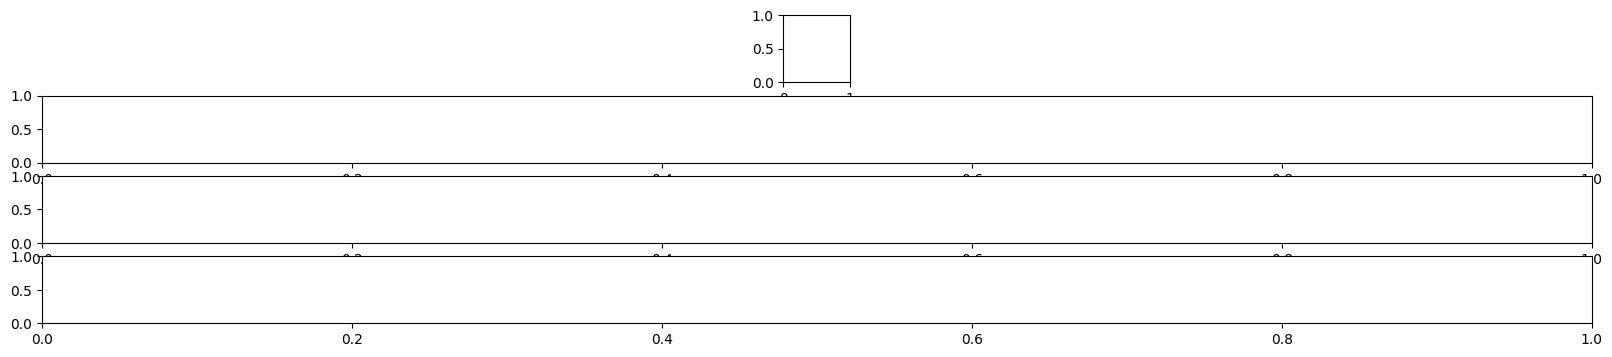

In [53]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r21','r31','r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

style_weights = [1e3/n**2 for n in [128,256,512,512]]
content_weights = [1e1]
weights = style_weights + content_weights



style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]
targets = style_targets + content_targets


img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch


tv_weights = [0,1e-6,3e-5,1e-3,1e-1]
results = []

for tv in tv_weights :
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()
    out = vgg_forward(input_image_p, loss_layers)
    layer_losses=[]
    total_loss= 0

    for i, weight in enumerate(weights):
      target = targets[i]
      feature = out[i]
      loss_fn = loss_fns[i]

      loss = weight * loss_fn(feature,target)
      layer_losses.append(loss.item())
      total_loss += loss

    total_loss = total_loss + tv * tv_loss(input_image_p)

    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






In [61]:

fig,axes = plt.subplots(1,5,figsize=(40,80))
for ax, img, w in zip(axes,results,tv_weights):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"TV weight ={w}")
  ax.axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [66]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r21','r31','r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

alpha = [1e-1,1e1,1e2,1e3,1e4,1e5]
beta =  1e1
results = []

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch

style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]

for a in alpha:
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()

    out_style = vgg_forward(input_image_p, style_layers)
    out_content = vgg_forward(input_image_p, content_layers)

    style_loss = sum(GramMSELoss()(f, t) for f, t in zip(out_style, style_targets))
    content_loss = sum(nn.MSELoss()(f, t) for f, t in zip(out_content, content_targets))

    total_loss = a * style_loss + beta * content_loss + 1e-6 * tv_loss(input_image_p)
    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Alpha={a}, Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






Alpha=0.1, Iteration 0: Total Loss = 0.2166
Alpha=0.1, Iteration 50: Total Loss = 0.2060
Alpha=0.1, Iteration 100: Total Loss = 0.1970
Alpha=0.1, Iteration 150: Total Loss = 0.1893
Alpha=0.1, Iteration 200: Total Loss = 0.1823
Alpha=0.1, Iteration 250: Total Loss = 0.1759
Alpha=0.1, Iteration 300: Total Loss = 0.1704
Alpha=0.1, Iteration 350: Total Loss = 0.1653
Alpha=0.1, Iteration 400: Total Loss = 0.1609
Alpha=0.1, Iteration 450: Total Loss = 0.1568
Alpha=10.0, Iteration 0: Total Loss = 0.2184
Alpha=10.0, Iteration 50: Total Loss = 0.2076
Alpha=10.0, Iteration 100: Total Loss = 0.1985
Alpha=10.0, Iteration 150: Total Loss = 0.1909
Alpha=10.0, Iteration 200: Total Loss = 0.1838
Alpha=10.0, Iteration 250: Total Loss = 0.1777
Alpha=10.0, Iteration 300: Total Loss = 0.1722
Alpha=10.0, Iteration 350: Total Loss = 0.1672
Alpha=10.0, Iteration 400: Total Loss = 0.1628
Alpha=10.0, Iteration 450: Total Loss = 0.1587
Alpha=100.0, Iteration 0: Total Loss = 0.2343
Alpha=100.0, Iteration 50: Tot

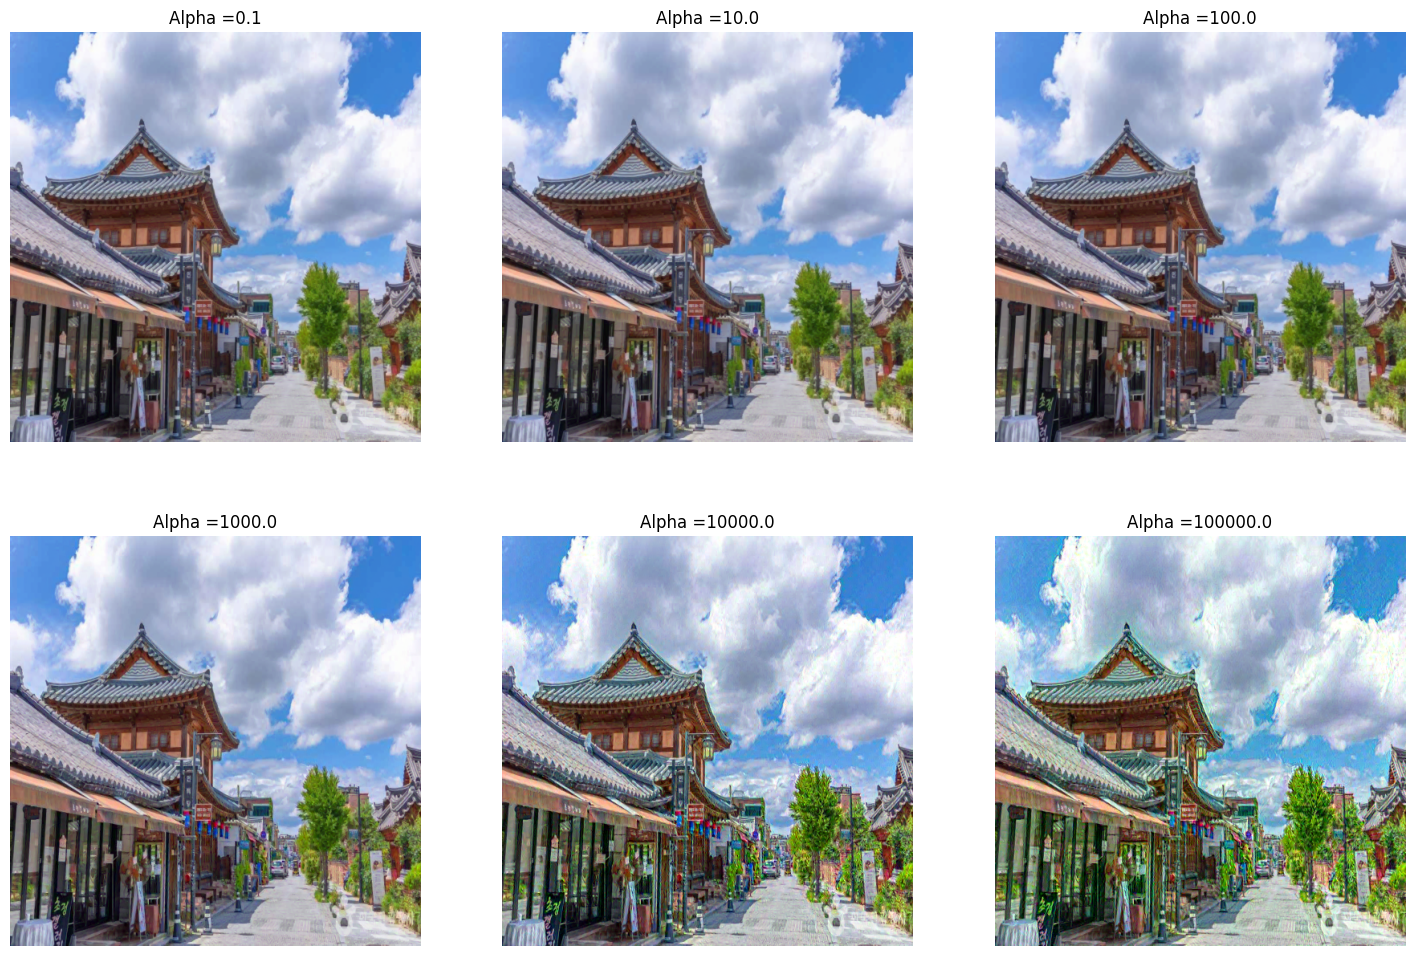

In [68]:

fig,axes = plt.subplots(2,3,figsize=(18,12))
for ax, img, a in zip(axes.flatten(),results, alpha):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"Alpha ={a}")
  ax.axis('off')

plt.show()

In [71]:
img1 = '/content/drive/MyDrive/DR_AI_응용/강의_7기_AI응용_6차시_신경망 스타일 전이/gihbri.png'
img2 = '/content/drive/MyDrive/DR_AI_응용/강의_7기_AI응용_6차시_신경망 스타일 전이/hanok.png'

img1 = Image.open(img1)
img2 = Image.open(img2)
imgs = []
imgs.append(img1)
imgs.append(img2)

img_size = 512
prep = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # RGB >> BGR 변환
        transforms.Normalize(mean = [0.40760392,0.45795686,0.48501961],
                             std=[1,1,1]),
        transforms.Lambda(lambda x: x.mul_(255))
    ]
)

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch


In [72]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r21','r31','r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

alpha = [1e-1,1e1,1e2,1e3,1e4,1e5]
beta =  1e1
results = []

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch

style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]

for a in alpha:
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()

    out_style = vgg_forward(input_image_p, style_layers)
    out_content = vgg_forward(input_image_p, content_layers)

    style_loss = sum(GramMSELoss()(f, t) for f, t in zip(out_style, style_targets))
    content_loss = sum(nn.MSELoss()(f, t) for f, t in zip(out_content, content_targets))

    total_loss = a * style_loss + beta * content_loss + 1e-6 * tv_loss(input_image_p)
    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Alpha={a}, Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






Alpha=0.1, Iteration 0: Total Loss = 0.1547
Alpha=0.1, Iteration 50: Total Loss = 0.1480
Alpha=0.1, Iteration 100: Total Loss = 0.1428
Alpha=0.1, Iteration 150: Total Loss = 0.1383
Alpha=0.1, Iteration 200: Total Loss = 0.1343
Alpha=0.1, Iteration 250: Total Loss = 0.1306
Alpha=0.1, Iteration 300: Total Loss = 0.1273
Alpha=0.1, Iteration 350: Total Loss = 0.1242
Alpha=0.1, Iteration 400: Total Loss = 0.1215
Alpha=0.1, Iteration 450: Total Loss = 0.1190
Alpha=10.0, Iteration 0: Total Loss = 0.1552
Alpha=10.0, Iteration 50: Total Loss = 0.1485
Alpha=10.0, Iteration 100: Total Loss = 0.1432
Alpha=10.0, Iteration 150: Total Loss = 0.1388
Alpha=10.0, Iteration 200: Total Loss = 0.1348
Alpha=10.0, Iteration 250: Total Loss = 0.1313
Alpha=10.0, Iteration 300: Total Loss = 0.1279
Alpha=10.0, Iteration 350: Total Loss = 0.1249
Alpha=10.0, Iteration 400: Total Loss = 0.1221
Alpha=10.0, Iteration 450: Total Loss = 0.1197
Alpha=100.0, Iteration 0: Total Loss = 0.1598
Alpha=100.0, Iteration 50: Tot

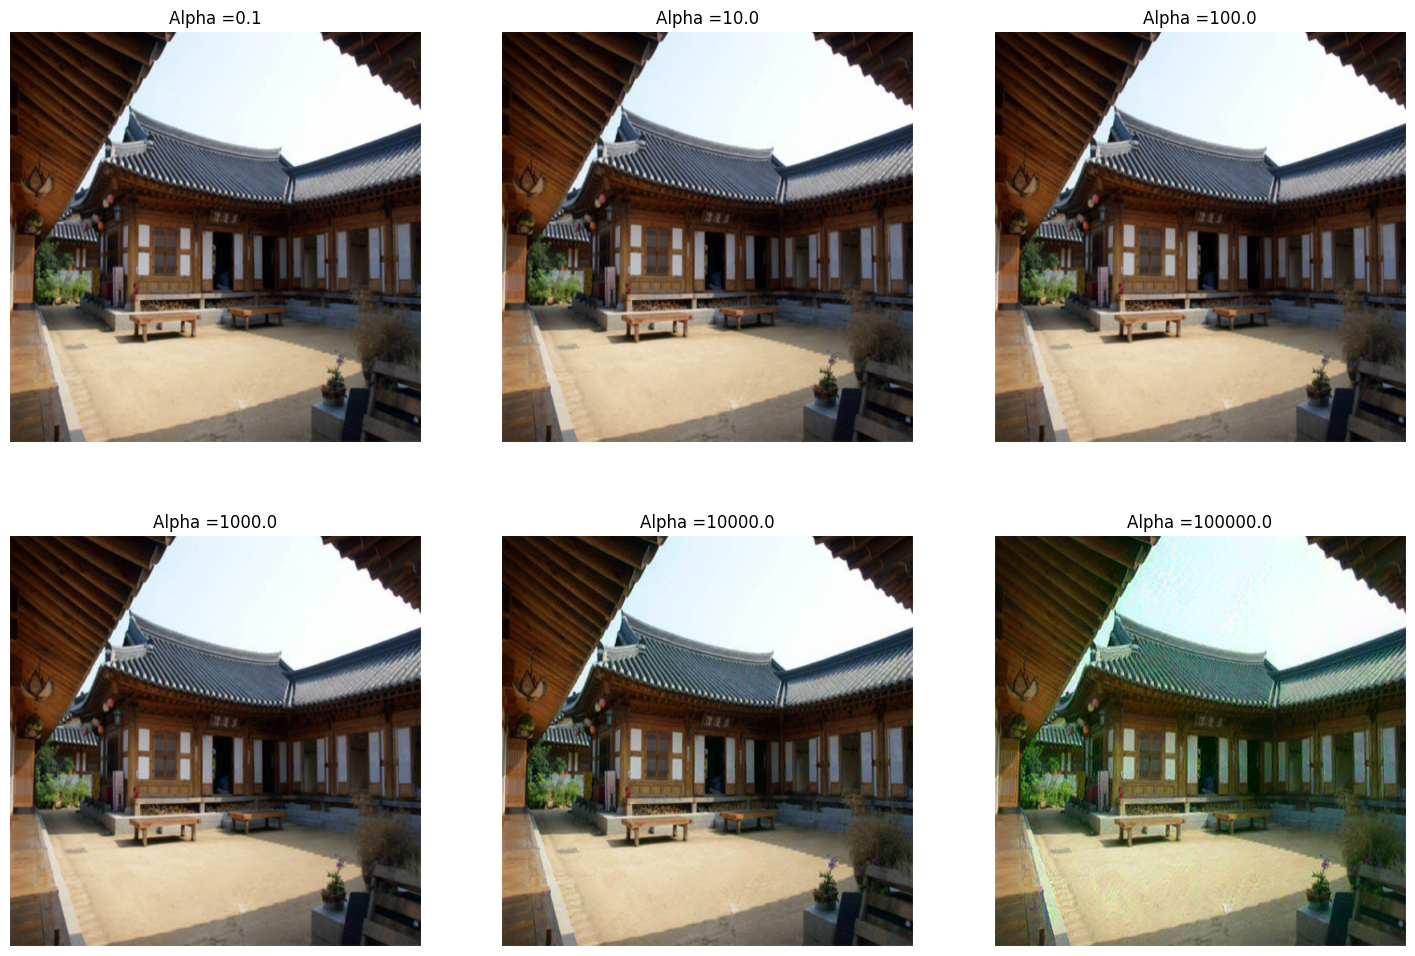

In [73]:
fig,axes = plt.subplots(2,3,figsize=(18,12))
for ax, img, a in zip(axes.flatten(),results, alpha):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"Alpha ={a}")
  ax.axis('off')

plt.show()

In [74]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r21','r31','r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

alpha = [1e2,1e4,1e6,1e8]
beta =  1e1
results = []

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch

style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]

for a in alpha:
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()

    out_style = vgg_forward(input_image_p, style_layers)
    out_content = vgg_forward(input_image_p, content_layers)

    style_loss = sum(GramMSELoss()(f, t) for f, t in zip(out_style, style_targets))
    content_loss = sum(nn.MSELoss()(f, t) for f, t in zip(out_content, content_targets))

    total_loss = a * style_loss + beta * content_loss + 3e-6 * tv_loss(input_image_p)
    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Alpha={a}, Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






Alpha=100.0, Iteration 0: Total Loss = 0.4691
Alpha=100.0, Iteration 50: Total Loss = 0.4374
Alpha=100.0, Iteration 100: Total Loss = 0.4161
Alpha=100.0, Iteration 150: Total Loss = 0.3970
Alpha=100.0, Iteration 200: Total Loss = 0.3800
Alpha=100.0, Iteration 250: Total Loss = 0.3657
Alpha=100.0, Iteration 300: Total Loss = 0.3529
Alpha=100.0, Iteration 350: Total Loss = 0.3418
Alpha=100.0, Iteration 400: Total Loss = 0.3315
Alpha=100.0, Iteration 450: Total Loss = 0.3229
Alpha=10000.0, Iteration 0: Total Loss = 0.9779
Alpha=10000.0, Iteration 50: Total Loss = 0.9110
Alpha=10000.0, Iteration 100: Total Loss = 0.8602
Alpha=10000.0, Iteration 150: Total Loss = 0.8205
Alpha=10000.0, Iteration 200: Total Loss = 0.7870
Alpha=10000.0, Iteration 250: Total Loss = 0.7588
Alpha=10000.0, Iteration 300: Total Loss = 0.7345
Alpha=10000.0, Iteration 350: Total Loss = 0.7136
Alpha=10000.0, Iteration 400: Total Loss = 0.6957
Alpha=10000.0, Iteration 450: Total Loss = 0.6804
Alpha=1000000.0, Iteration

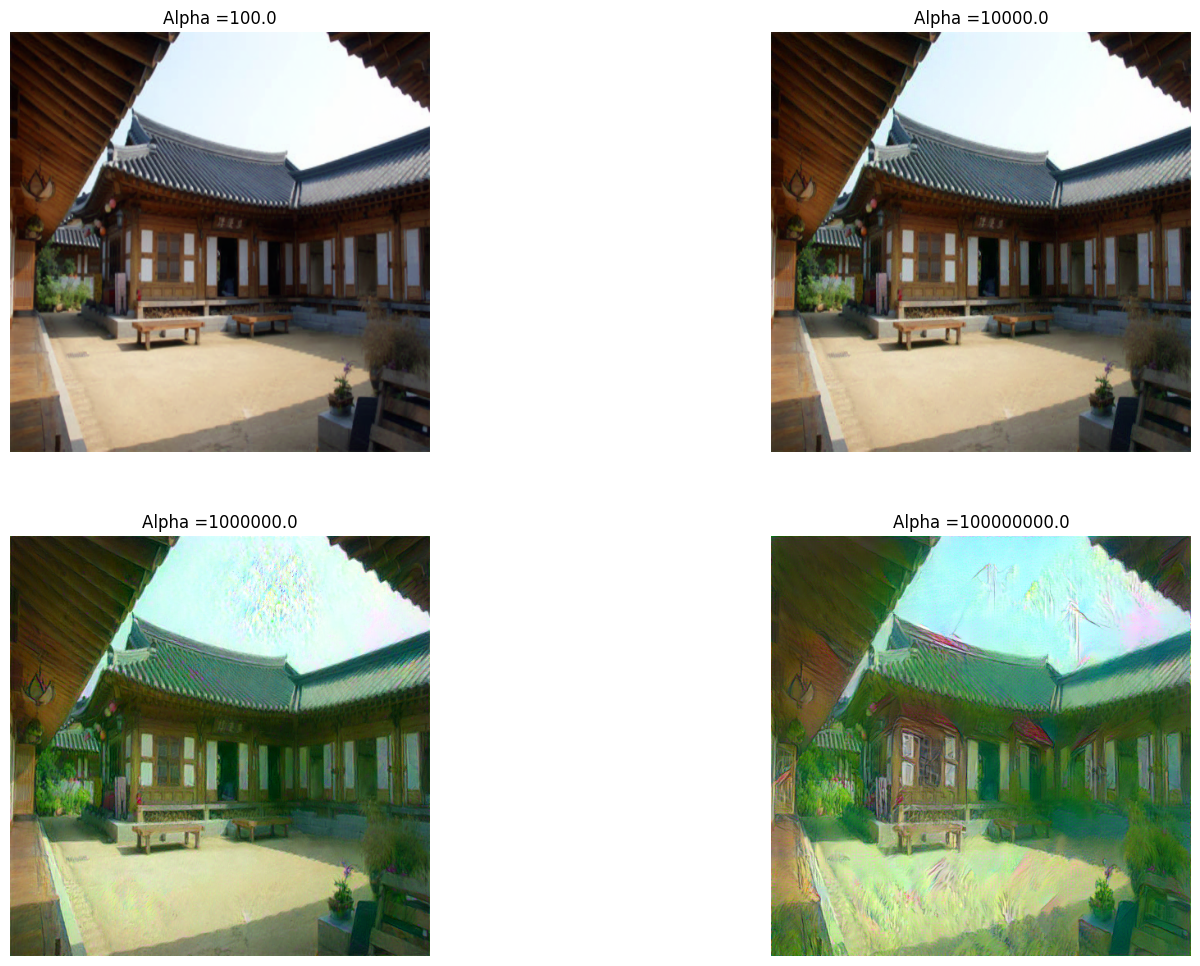

In [75]:
fig,axes = plt.subplots(2,2,figsize=(18,12))
for ax, img, a in zip(axes.flatten(),results, alpha):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"Alpha ={a}")
  ax.axis('off')

plt.show()

In [76]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r41','r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

alpha = [1e6,1e8]
beta =  1e1
results = []

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch

style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]

for a in alpha:
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()

    out_style = vgg_forward(input_image_p, style_layers)
    out_content = vgg_forward(input_image_p, content_layers)

    style_loss = sum(GramMSELoss()(f, t) for f, t in zip(out_style, style_targets))
    content_loss = sum(nn.MSELoss()(f, t) for f, t in zip(out_content, content_targets))

    total_loss = a * style_loss + beta * content_loss + 3e-6 * tv_loss(input_image_p)
    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Alpha={a}, Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






Alpha=1000000.0, Iteration 0: Total Loss = 12.7188
Alpha=1000000.0, Iteration 50: Total Loss = 8.2561
Alpha=1000000.0, Iteration 100: Total Loss = 7.9394
Alpha=1000000.0, Iteration 150: Total Loss = 7.7714
Alpha=1000000.0, Iteration 200: Total Loss = 7.6576
Alpha=1000000.0, Iteration 250: Total Loss = 7.5704
Alpha=1000000.0, Iteration 300: Total Loss = 7.4968
Alpha=1000000.0, Iteration 350: Total Loss = 7.4298
Alpha=1000000.0, Iteration 400: Total Loss = 7.3640
Alpha=1000000.0, Iteration 450: Total Loss = 7.2989
Alpha=100000000.0, Iteration 0: Total Loss = 1225.9509
Alpha=100000000.0, Iteration 50: Total Loss = 69.7570
Alpha=100000000.0, Iteration 100: Total Loss = 58.4340
Alpha=100000000.0, Iteration 150: Total Loss = 54.2782
Alpha=100000000.0, Iteration 200: Total Loss = 51.9672
Alpha=100000000.0, Iteration 250: Total Loss = 50.5354
Alpha=100000000.0, Iteration 300: Total Loss = 49.5292
Alpha=100000000.0, Iteration 350: Total Loss = 48.7997
Alpha=100000000.0, Iteration 400: Total Los

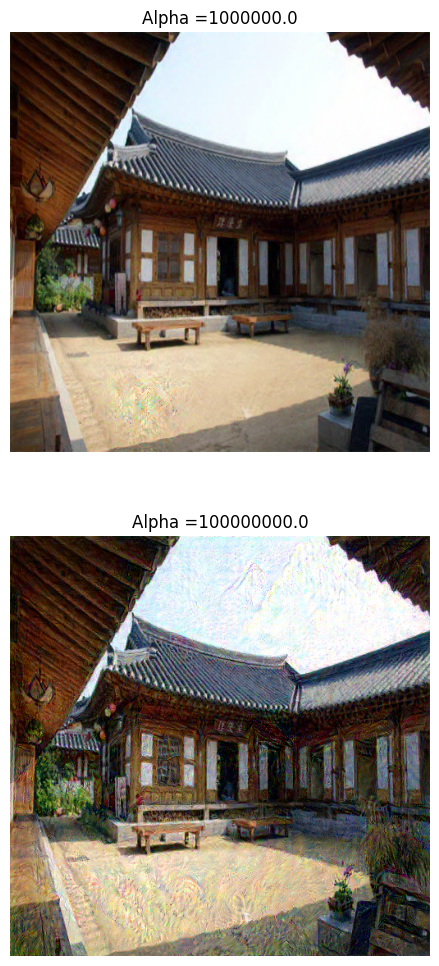

In [77]:
fig,axes = plt.subplots(2,1,figsize=(18,12))
for ax, img, a in zip(axes.flatten(),results, alpha):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"Alpha ={a}")
  ax.axis('off')

plt.show()

In [78]:
vgg_pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_pretrained = vgg_pretrained.to(device).eval()

for param in vgg_pretrained.parameters():
  param.requires_grad = False

layer_map = {
    'r11': 1,
    'r12': 3,
    'r21': 6,
    'r22': 8,
    'r31': 11,
    'r32': 13,
    'r33': 15,
    'r34': 17,
    'r41': 20,
    'r42': 22,
    'r43': 24,
    'r44': 26,
    'r51': 29,
    'r52': 31,
    'r53': 33,
    'r54': 35,
}

img_size = 512
prep = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])
style_layers = ['r31','r41','r51']
content_layers = ['r51']
loss_layers = style_layers + content_layers

loss_fn = [GramMSELoss()]*len(style_layers) + [nn.MSELoss()]*len(content_layers)
loss_fns = [GramMSELoss().to(device) for _ in  style_layers]+[nn.MSELoss().to(device) for _ in content_layers]

alpha = [1e4,1e6,1e8]
beta =  1e1
results = []

img_torch = [prep(img).unsqueeze(0).to(device) for img in imgs]
style_img, content_img = img_torch

style_targets = [GramMatrix()(A) for A in vgg_forward(style_img, style_layers)]
content_targets = [A for A in vgg_forward(content_img, content_layers)]

for a in alpha:
  input_image_p = content_img.clone().requires_grad_(True)
  optimizer = torch.optim.LBFGS([input_image_p], max_iter=500)
  n_iter = 0

  def closure():
    global n_iter

    optimizer.zero_grad()

    out_style = vgg_forward(input_image_p, style_layers)
    out_content = vgg_forward(input_image_p, content_layers)

    style_loss = sum(GramMSELoss()(f, t) for f, t in zip(out_style, style_targets))
    content_loss = sum(nn.MSELoss()(f, t) for f, t in zip(out_content, content_targets))

    total_loss = a * style_loss + beta * content_loss + 3e-6 * tv_loss(input_image_p)
    total_loss.backward()

    if n_iter % 50 == 0:
      print(f'Alpha={a}, Iteration {n_iter}: Total Loss = {total_loss.item():.4f}')

    n_iter += 1
    return total_loss

  optimizer.step(closure)
  img_show = denormalize(input_image_p).clamp(0,1)
  results.append(img_show.detach().cpu())






Alpha=10000.0, Iteration 0: Total Loss = 0.8622
Alpha=10000.0, Iteration 50: Total Loss = 0.7375
Alpha=10000.0, Iteration 100: Total Loss = 0.6659
Alpha=10000.0, Iteration 150: Total Loss = 0.6156
Alpha=10000.0, Iteration 200: Total Loss = 0.5765
Alpha=10000.0, Iteration 250: Total Loss = 0.5443
Alpha=10000.0, Iteration 300: Total Loss = 0.5174
Alpha=10000.0, Iteration 350: Total Loss = 0.4951
Alpha=10000.0, Iteration 400: Total Loss = 0.4761
Alpha=10000.0, Iteration 450: Total Loss = 0.4596
Alpha=1000000.0, Iteration 0: Total Loss = 40.2906
Alpha=1000000.0, Iteration 50: Total Loss = 4.8484
Alpha=1000000.0, Iteration 100: Total Loss = 3.7012
Alpha=1000000.0, Iteration 150: Total Loss = 3.2979
Alpha=1000000.0, Iteration 200: Total Loss = 3.0820
Alpha=1000000.0, Iteration 250: Total Loss = 2.9437
Alpha=1000000.0, Iteration 300: Total Loss = 2.8450
Alpha=1000000.0, Iteration 350: Total Loss = 2.7695
Alpha=1000000.0, Iteration 400: Total Loss = 2.7097
Alpha=1000000.0, Iteration 450: Total

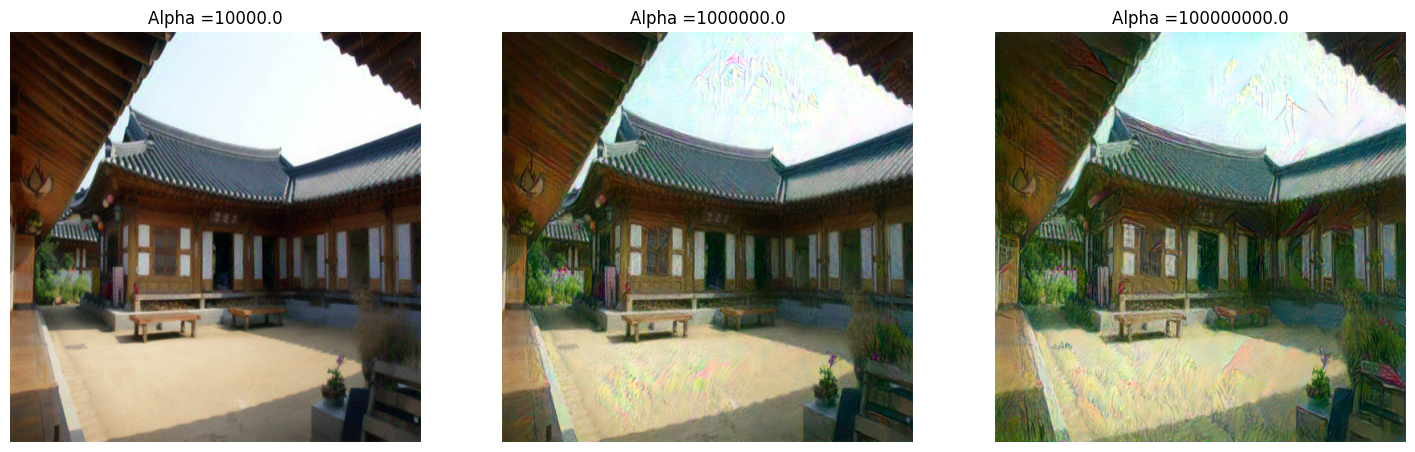

In [81]:
fig,axes = plt.subplots(1,3,figsize=(18,12))
for ax, img, a in zip(axes.flatten(),results, alpha):
  ax.imshow(img.squeeze(0).permute(1,2,0))
  ax.set_title(f"Alpha ={a}")
  ax.axis('off')

plt.show()